In [4]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

In [5]:
from sklearn.metrics import roc_auc_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
#pd.options.mode.chained_assignment = None
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV

In [6]:
from etl import get_to_know_data,plot1,data_clean,do_pca,scree_plot_1,scree_plot_2,model_kmeans

# Part 0: Data EDA 

In [7]:
azdias=pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';')

C:\Users\Xue Wang\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [5]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [8]:
customers = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv', sep=';')

In [9]:
# As the information from the description, there are three extra columns from the CUSTOMERS file, which don't need
customers=customers.drop(['CUSTOMER_GROUP','ONLINE_PURCHASE','PRODUCT_GROUP'],axis=1)

In [8]:
get_to_know_data(azdias)

shape: (891221, 366)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 2.4+ GB
info: None

Thers is 0 duplicated records


In [9]:
%%time
get_to_know_data(customers)

shape: (191652, 366)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 535.2+ MB
info: None

Thers is 0 duplicated records
Wall time: 7.58 s


null value percentage description:        percentage
count  366.000000
mean     0.102680
std      0.121640
min      0.000000
25%      0.000000
50%      0.118714
75%      0.120230
max      0.998648
Wall time: 7.82 s


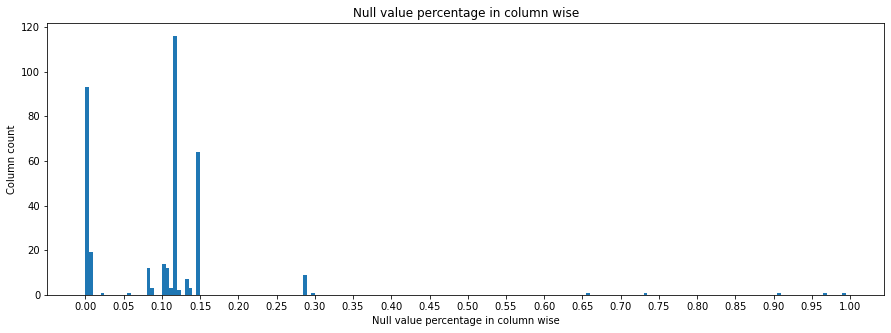

In [12]:
%%time
plot1(azdias)

null value percentage description:        percentage
count  366.000000
mean     0.197656
std      0.151007
min      0.000000
25%      0.000000
50%      0.267574
75%      0.267574
max      0.998769
Wall time: 937 ms


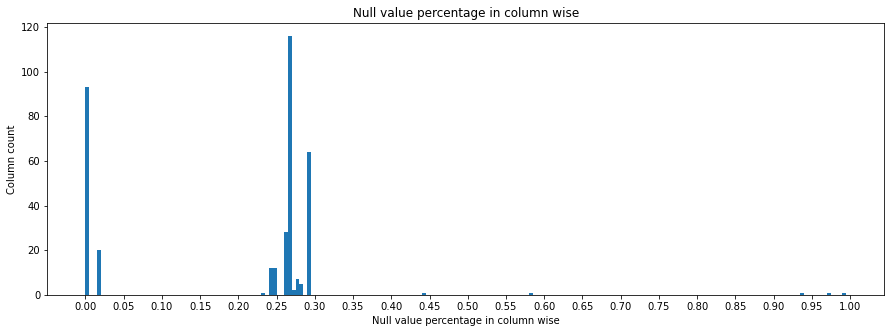

In [13]:
%%time
plot1(customers)

In [10]:
# read the Attributes file
value_17 = pd.read_excel('DIAS Attributes - Values 2017.xlsx',header=None)

In [11]:
def null_attributes_list(val_17):
    '''
    get the unknown values list from the attributes excel file
    input: attributes file as pd
    output: unknown value feature and list 
    '''
    # get the records with col 4 with the value as unknown
    val_17_unknown=val_17[val_17.iloc[:,4].isin(['unknown','unknown / no main age detectable'])]
    # rename the column names
    val_17_unknown=val_17_unknown.rename(columns={1:'feature',2:'fea_dis',3:'null_val'})
    # choose the target two columns
    val_17_unknown=val_17_unknown[['feature','null_val']]
    # reset index
    val_17_unknown.reset_index(drop=True, inplace=True)
    # There are two types of data in null_val one, int and str. In order to be used, they need to be transferred into one format as list
    # The target is to get the same format list, the difficulty is to how to deal with the variable lengthe variable
    val=[]
    for i in val_17_unknown['null_val']:
        if type(i)==int:
            val.append([i]) # if it is int, append it as  a list to val
        if type(i)==str:
            val1=list(map(int, i.split(',')))# if it is a string, first split it, then map them as int, and then save as a list
            val.append(val1) # now append the list to value
    # create a new column to save the val created as above
    val_17_unknown['new']=val
    # save value_2017_null_feature_1 as csv, then don't need to run above codes
    return val_17_unknown
    #val_17_unknown.to_csv('1_value_2017_null_features.csv',index=False)

In [12]:
null_list_attributes_2017=null_attributes_list(value_17)

In [375]:
null_list_attributes_2017.head()

,feature,null_val,new
0,AGER_TYP,-1,[-1]
1,ALTERSKATEGORIE_GROB,"-1, 0","[-1, 0]"
2,ALTER_HH,0,[0]
3,ANREDE_KZ,"-1, 0","[-1, 0]"
4,BALLRAUM,-1,[-1]


In [13]:
df_a=azdias

In [14]:
%%time
azdias_cleaned, azdias_index=data_clean(null_list_attributes_2017,df_a)

Wall time: 1min 21s


In [15]:
df_c=customers

In [16]:
%%time
customers_cleaned,customers_index=data_clean(null_list_attributes_2017,df_c)

Wall time: 13.2 s


# Part 1: Customer Segmentation Report

## PCA

In [17]:
data=azdias_cleaned

In [20]:
%%time
pca_a, X_pca_a = do_pca(358,data)

Wall time: 3min 11s


In [21]:
data.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,2.0,1.0,18.0,15.0,1.0,0.0,0.0,1.0,1.0,0.0,...,2.0,10.0,10.0,10.0,6.0,9.0,3.0,3,1,2
1,2.0,9.0,18.0,21.0,11.0,0.0,0.0,2.0,12.0,0.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,2.0,9.0,17.0,17.0,10.0,0.0,0.0,1.0,7.0,0.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,2.0,1.0,13.0,13.0,1.0,0.0,0.0,0.0,2.0,0.0,...,0.0,7.0,10.0,11.0,6.0,9.0,7.0,3,2,4
4,2.0,1.0,20.0,14.0,3.0,0.0,0.0,4.0,3.0,0.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [23]:
pca_a

PCA(n_components=358)

Wall time: 836 ms


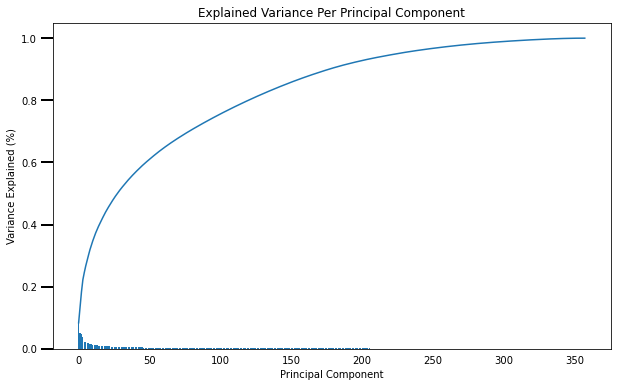

In [24]:
%%time
scree_plot_1(pca_a)

In [25]:
data=azdias_cleaned

In [18]:
%%time
pca_a, X_pca_a = do_pca(15,data )

Wall time: 1min 38s


Wall time: 398 ms


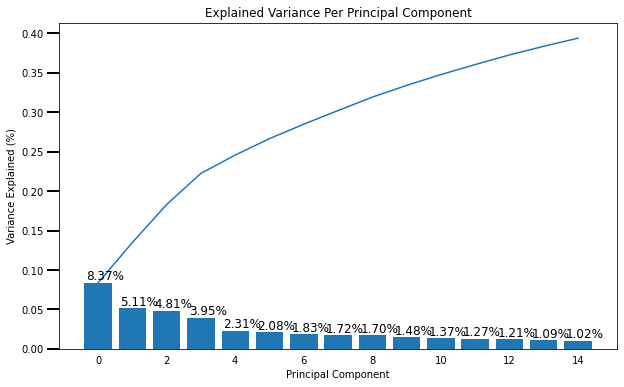

In [19]:
%%time
scree_plot_2(pca_a)

In [ ]:
# below codes to display how the compnents of PCA looks like

Choose n_component=15 to balance the running time and performance

# Find the best K

Wall time: 0 ns


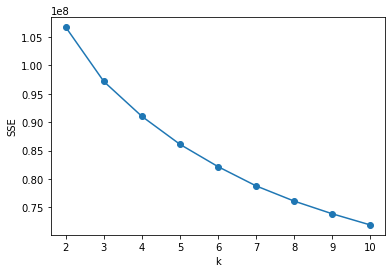

Wall time: 5min 20s


In [27]:
%%time
est=model_kmeans(10, X_pca_a)

In [ ]:
I have tried K =20, but taking one hour without results yet, so I take ks=10 which I think it also makes sense.

In [29]:
ks=10

%%time
k_means = KMeans(init = "k-means++", n_clusters = ks,random_state=42)

Wall time: 0 ns


In [30]:
%%time
# use the best model to fit again
model_k_a=k_means.fit(X_pca_a)

Wall time: 58.9 s


In [31]:
model_k_a.labels_

array([0, 3, 3, ..., 3, 4, 9])

In [ ]:
# now display the pca components

In [356]:
dim_a =['Dimension' +str(i) for i in range(1,len(pca_a.components_)+1)]
comp_dist_a=pd.DataFrame(np.round(pca_a.components_,5),columns=azdias_col)
comp_dist_a.index=dim

In [357]:
comp_dist_a.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
Dimension1,-0.02113,-0.05735,0.00083,-0.00998,-0.06305,-0.01475,0.04180,0.09280,-0.06213,0.00336,...,-0.02776,-0.11607,-0.11362,-0.10051,-0.07583,0.00914,0.04469,-0.07288,-0.00491,0.02245
Dimension2,0.02670,-0.00099,0.06995,0.08966,0.03950,0.00134,0.05934,0.07212,0.03654,-0.00335,...,0.00836,-0.12336,-0.09182,-0.05955,-0.09700,-0.05552,-0.00362,0.04270,0.00262,-0.08120
Dimension3,0.01508,0.01388,0.01485,0.02121,0.03469,0.02862,0.01224,0.01080,0.03252,0.01077,...,0.04648,-0.02483,-0.01045,-0.00266,-0.01910,-0.02453,-0.08170,0.00276,0.00445,-0.02448
Dimension4,-0.06536,-0.05174,-0.14184,-0.14281,0.04815,0.02519,-0.03377,0.02304,0.05025,0.01088,...,0.03103,-0.03841,-0.07569,-0.12031,0.03525,0.03722,-0.02805,-0.04186,-0.01497,0.16314
Dimension5,0.01688,-0.01669,0.02135,0.02816,-0.00540,0.00812,0.00126,-0.01248,-0.00220,0.00264,...,-0.03117,0.00076,-0.01517,-0.00018,0.00338,-0.00276,-0.05840,-0.00356,0.02847,-0.03767


In [359]:
print('Principal Component 0: ')
print('Top 5 features: ')
print(comp_dist_a.iloc[0].sort_values(ascending=False)[:5])
print('Bottom 5 features: ')
print(comp_dist_a.iloc[0].sort_values(ascending=False)[-5:])
print('Variance Explained: ',pca_a.explained_variance_ratio_[0]*100)

Principal Component 0: 
Top 5 features: 
MOBI_RASTER       0.12214
PLZ8_ANTG1        0.12175
KBA13_ANTG1       0.12070
MOBI_REGIO        0.12062
LP_STATUS_GROB    0.11747
Name: Dimension1, dtype: float64
Bottom 5 features: 
VK_DHT4A          -0.11607
CAMEO_INTL_2015   -0.11830
CAMEO_DEUG_2015   -0.12097
PLZ8_ANTG3        -0.12194
KBA13_ANTG3       -0.12207
Name: Dimension1, dtype: float64
Variance Explained:  8.375648631703452


In [20]:
azdias_col=azdias.columns

In [ ]:
# get the cluster labels
a_cluster_1=pd.DataFrame(model_k_a.labels_, columns=['cluster'])  # 0-9,一共10个标签
# combine the cluster and cleaned azdias data
X_full_a=pd.concat([azdias_cleaned,a_cluster],axis=1)

## Use this trained model to predict on X_pca_customer

In [38]:
data_c=customers_cleaned

In [40]:
%%time
pca_c, X_pca_c = do_pca(15,data_c)

Wall time: 16.2 s


In [42]:
%%time
predict_c=model_k_a.predict(X_pca_c)

Wall time: 158 ms


In [43]:
c_cluster=pd.DataFrame(predict_c, columns=['cluster']) 

In [44]:
# combine the cluster and cleaned azdias data
X_full_c=pd.concat([customers_cleaned,c_cluster],axis=1)

# Anlyzing the cluster for AZDIAS and CUSTOMER

In [ ]:
1. Compare the cluster percentage

In [45]:
X_full_a.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 359 entries, AGER_TYP to cluster
dtypes: float64(268), int32(1), int64(90)
memory usage: 2.4 GB


In [46]:
X_full_c.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Columns: 359 entries, AGER_TYP to cluster
dtypes: float64(268), int32(1), int64(90)
memory usage: 524.2 MB


Analysis the cluster percentage 

In [48]:
df_cluster_percentage_a = (X_full_a.cluster.value_counts()/X_full_a.shape[0]).sort_values(ascending=False).rename_axis('cluster').reset_index(name='percent')

In [49]:
df_cluster_percentage_c = (X_full_c.cluster.value_counts()/X_full_c.shape[0]).sort_values(ascending=False).rename_axis('cluster').reset_index(name='percent')

In [51]:
df_cluster_percentage_c

,cluster,percent
0,1,0.252473
1,9,0.168978
2,3,0.165634
3,6,0.147251
4,5,0.082201
5,8,0.076983
6,2,0.072496
7,4,0.018074
8,0,0.012424
9,7,0.003485


In [52]:
df_cluster_percentage=df_cluster_percentage_c.merge(df_cluster_percentage_a, how='inner', on='cluster')

df_cluster_percentage.columns=['cluster','customer(%)','population(%)']

In [53]:
df_cluster_percentage=df_cluster_percentage.round(2)

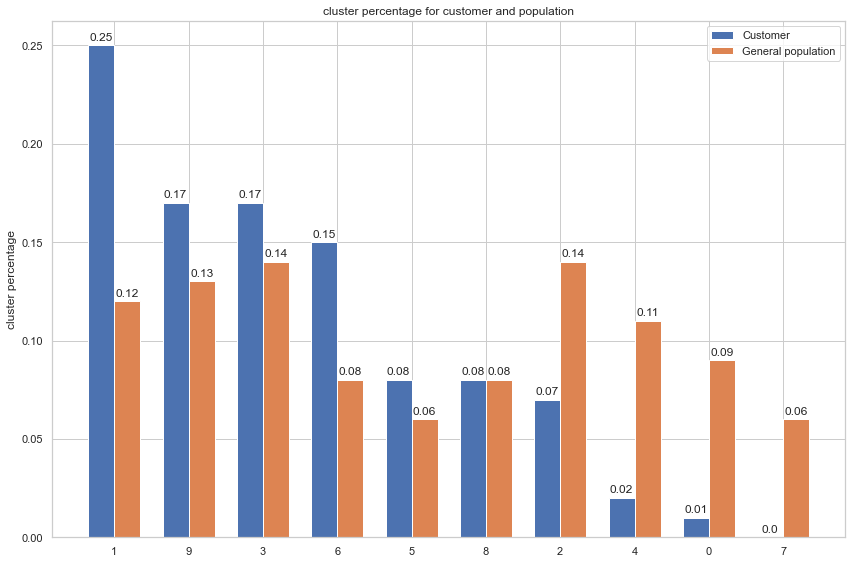

In [374]:
labels =df_cluster_percentage['cluster'] 
customer_percentage = df_cluster_percentage['customer(%)']
population_percentage = df_cluster_percentage['population(%)']

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig_dims = (12, 8)
fig, ax = plt.subplots(figsize=fig_dims)
#fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, customer_percentage, width, label='Customer')
rects2 = ax.bar(x + width/2,population_percentage, width, label='General population')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('cluster percentage')
ax.set_title('cluster percentage for customer and population')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()


The percentage of clusters 1,9,3,6,5 has increased in customers, which shows the potential to become of customer

Now analysis the cluster combinning with the top features from component 0

In [299]:
X_full_c_1=X_full_c.loc[X_full_c['cluster']==1,['MOBI_RASTER','PLZ8_ANTG1','KBA13_ANTG1','MOBI_REGIO','LP_STATUS_GROB','VK_DHT4A','CAMEO_DEUG_2015','PLZ8_ANTG3','KBA13_ANTG3']]

In [300]:
X_full_a_1=X_full_a.loc[X_full_a['cluster']==1,['MOBI_RASTER','PLZ8_ANTG1','KBA13_ANTG1','MOBI_REGIO','LP_STATUS_GROB','VK_DHT4A','CAMEO_DEUG_2015','PLZ8_ANTG3','KBA13_ANTG3']]

In [301]:
X_full_c_1=X_full_c_1.mean()

In [302]:
X_full_c_1 = pd.Series(X_full_c_1, name="Customers")

In [303]:
X_full_c_1

MOBI_RASTER        1.022299
PLZ8_ANTG1         2.003059
KBA13_ANTG1        2.001922
MOBI_REGIO         4.993366
LP_STATUS_GROB     2.210614
VK_DHT4A           1.108934
CAMEO_DEUG_2015    2.019447
PLZ8_ANTG3         1.004071
KBA13_ANTG3        1.005084
Name: Customers, dtype: float64

In [304]:
X_full_a_1=X_full_a_1.mean()

In [305]:
X_full_a_1 = pd.Series(X_full_a_1, name="General population")

In [306]:
cluster_1 = pd.concat([X_full_c_1, X_full_a_1], axis=1)

In [307]:
cluster_1

,Customers,General population
MOBI_RASTER,1.022299,1.356204
PLZ8_ANTG1,2.003059,1.829278
KBA13_ANTG1,2.001922,1.742122
MOBI_REGIO,4.993366,1.917358
LP_STATUS_GROB,2.210614,1.615016
VK_DHT4A,1.108934,7.808836
CAMEO_DEUG_2015,2.019447,7.142205
PLZ8_ANTG3,1.004071,2.086096
KBA13_ANTG3,1.005084,2.164281


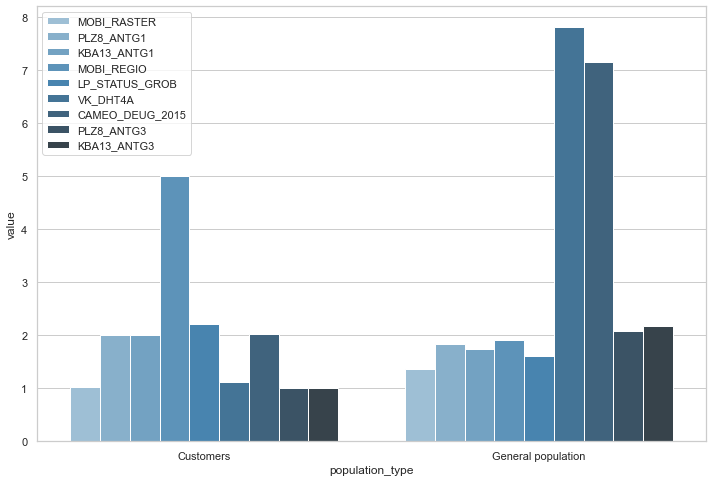

In [308]:
fig_dims = (12, 8)
fig, ax = plt.subplots(figsize=fig_dims)

sns.barplot(x='population_type', y='value', hue='index',ax=ax,palette="Blues_d",
            data=cluster_1.reset_index().melt(id_vars='index', var_name='population_type'))
plt.legend(loc='upper left')


In [314]:
X_full_c_1_cameo=X_full_c.loc[X_full_c['cluster']==1,['CAMEO_INTL_2015']]

In [315]:
X_full_a_1_cameo=X_full_a.loc[X_full_a['cluster']==1,['CAMEO_INTL_2015']]

In [382]:
X_full_c_1_cameo=X_full_c_1_cameo.mean()

In [383]:
X_full_c_1_cameo

14.133775600884535

In [317]:
X_full_c_1_cameo = pd.Series(X_full_c_1_cameo, name="Customers")

In [318]:
X_full_a_1_cameo=X_full_a_1_cameo.mean()

In [384]:
X_full_a_1_cameo

CAMEO_INTL_2015    45.487707
Name: General population, dtype: float64

In [319]:
X_full_a_1_cameo = pd.Series(X_full_a_1_cameo, name="General population")

In [320]:
cluster_1_cameo = pd.concat([X_full_c_1_cameo, X_full_a_1_cameo], axis=1)

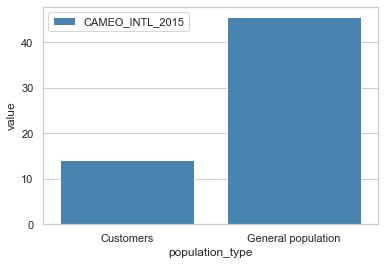

In [323]:
fig_dims = (6, 4)
fig, ax = plt.subplots(figsize=fig_dims)

sns.barplot(x='population_type', y='value', hue='index',ax=ax,palette="Blues_d",
            data=cluster_1_cameo.reset_index().melt(id_vars='index', var_name='population_type'))
plt.legend(loc='upper left')

Now analysis MOBI_RASATER for all clusters

In [98]:
X_MOBI_RASTER_c=X_full_c.groupby('cluster')[['MOBI_RASTER']].mean().rename_axis('cluster').reset_index()

In [99]:
X_MOBI_RASTER_a=X_full_a.groupby('cluster')[['MOBI_RASTER']].mean().rename_axis('cluster').reset_index()

In [100]:
X_MOBI_RASTER_c

,cluster,MOBI_RASTER
0,0,3.556069
1,1,1.022299
2,2,2.730963
3,3,3.195817
4,4,1.216224
5,5,3.217913
6,6,1.356401
7,7,1.829341
8,8,3.062559
9,9,3.830848


In [101]:
X_MOBI_RASTER_c=X_MOBI_RASTER_c.rename(columns={'MOBI_RASTER': 'percent'})

In [102]:
X_MOBI_RASTER_a=X_MOBI_RASTER_a.rename(columns={'MOBI_RASTER': 'percent'})

In [103]:
X_MOBI_RASTER_c=X_MOBI_RASTER_c.round(2)

In [104]:
X_MOBI_RASTER_a=X_MOBI_RASTER_a.round(2)

In [105]:
X_MOBI_RASTER_c['percent']

0    3.56
1    1.02
2    2.73
3    3.20
4    1.22
5    3.22
6    1.36
7    1.83
8    3.06
9    3.83
Name: percent, dtype: float64

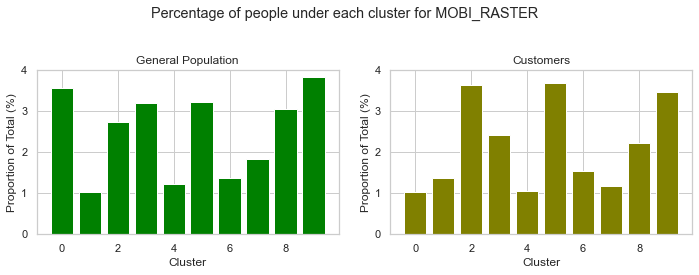

In [381]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 4))
ax1.bar(X_MOBI_RASTER_c['cluster'], X_MOBI_RASTER_c['percent'],color='green')
ax1.set_xlabel("Cluster")
ax1.set_ylabel("Proportion of Total (%)")
ax1.set_title("General Population")
ax1.set_ylim([0,4])



ax2.bar(X_MOBI_RASTER_a['cluster'], X_MOBI_RASTER_a['percent'],color='olive')
ax2.set_xlabel("Cluster")
ax2.set_ylabel("Proportion of Total (%)")
ax2.set_title("Customers")
ax2.set_ylim([0,4])
ax2.plot(color='red')


fig.suptitle("Percentage of people under each cluster for MOBI_RASTER")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

# Part2: Customer labeling

In [101]:
mailout_train = pd.read_csv('data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
mailout_test = pd.read_csv('data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

C:\Users\Xue Wang\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [103]:
%%time
train_cleaned, train_index=data_clean(null_list_attributes_2017, mailout_train)

Wall time: 3.12 s


In [104]:
y_label = train_cleaned['RESPONSE']
del train_cleaned['RESPONSE']

In [105]:
test_cleaned,test_index=data_clean(null_list_attributes_2017,mailout_test)

In [106]:
# Split the dataset into Train/Validation/Test
X_train, X_test, y_train, y_test = train_test_split(train_cleaned, y_label, test_size=0.2,random_state=42)

In [109]:
X_train.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
33746,2.0,1.0,9.0,9.0,1.0,0.0,0.0,1.0,1.0,0.0,...,2.0,1.0,1.0,1.0,6.0,9.0,3.0,3,1,2
626,2.0,9.0,9.0,0.0,1.0,0.0,0.0,3.0,1.0,0.0,...,2.0,1.0,1.0,1.0,6.0,9.0,7.0,1,2,4
32367,2.0,1.0,9.0,9.0,1.0,0.0,0.0,2.0,1.0,0.0,...,3.0,1.0,1.0,1.0,6.0,9.0,1.0,3,2,4
29099,2.0,1.0,9.0,8.0,1.0,0.0,0.0,2.0,1.0,0.0,...,0.0,1.0,1.0,1.0,6.0,9.0,3.0,1,1,4
27575,2.0,1.0,16.0,15.0,1.0,0.0,2.0,2.0,2.0,0.0,...,3.0,3.0,6.0,6.0,1.0,7.0,2.0,4,2,2


In [110]:
y_train.head()

33746    0
626      0
32367    0
29099    0
27575    0
Name: RESPONSE, dtype: int64

In [108]:
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (34369, 358) (34369,)
Test set: (8593, 358) (8593,)


### The dataset is imbalance, use smote to balance it

In [111]:
over_samples=SMOTE(random_state=42)

In [112]:
%%time
over_sampling_X,over_sampling_y=over_samples.fit_sample(X_train, y_train)

Wall time: 2.72 s


In [113]:
X_train_sa, y_train_sa=over_sampling_X,over_sampling_y

In [114]:
X_train_sa.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,2.0,1.0,9.0,9.0,1.0,0.0,0.0,1.0,1.0,0.0,...,2.0,1.0,1.0,1.0,6.0,9.0,3.0,3,1,2
1,2.0,9.0,9.0,0.0,1.0,0.0,0.0,3.0,1.0,0.0,...,2.0,1.0,1.0,1.0,6.0,9.0,7.0,1,2,4
2,2.0,1.0,9.0,9.0,1.0,0.0,0.0,2.0,1.0,0.0,...,3.0,1.0,1.0,1.0,6.0,9.0,1.0,3,2,4
3,2.0,1.0,9.0,8.0,1.0,0.0,0.0,2.0,1.0,0.0,...,0.0,1.0,1.0,1.0,6.0,9.0,3.0,1,1,4
4,2.0,1.0,16.0,15.0,1.0,0.0,2.0,2.0,2.0,0.0,...,3.0,3.0,6.0,6.0,1.0,7.0,2.0,4,2,2


##  For some model, it is needed to standardscale the X_train_sa set

In [115]:
sc_X=StandardScaler()

In [116]:
%%time
X_train_sa_st=sc_X.fit_transform(X_train_sa)

Wall time: 1.86 s


In [122]:
len(X_train_sa_st)

67916

In [119]:
X_train_sa_st

array([[ 0.42006396, -0.24822878, -0.57849048, ...,  0.3649585 ,
        -0.96666063, -1.08043756],
       [ 0.42006396,  5.63885358, -0.57849048, ..., -1.56162979,
         1.03448922,  0.81764693],
       [ 0.42006396, -0.24822878, -0.57849048, ...,  0.3649585 ,
         1.03448922,  0.81764693],
       ...,
       [ 2.28940685, -0.24822878,  0.2276733 , ...,  0.3649585 ,
         1.03448922, -0.13139532],
       [ 0.42006396, -0.24822878,  0.20447138, ...,  0.3649585 ,
        -0.96666063,  0.81764693],
       [ 0.42006396, -0.24822878, -0.57849048, ...,  0.3649585 ,
        -0.96666063, -2.0294798 ]])

In [117]:
X_test_st=sc_X.transform(X_test)

In [121]:
len(X_test_st)

8593

In [120]:
X_test_st

array([[-1.44927893, -0.24822878,  1.40972239, ...,  1.32825265,
         1.03448922,  0.81764693],
       [ 0.42006396, -0.24822878,  2.82987444, ..., -1.56162979,
        -0.96666063, -0.13139532],
       [-1.44927893, -0.24822878,  0.27360075, ...,  0.3649585 ,
         1.03448922, -0.13139532],
       ...,
       [ 0.42006396, -0.24822878, -0.57849048, ...,  0.3649585 ,
         1.03448922, -2.0294798 ],
       [-1.44927893, -0.24822878, -0.57849048, ...,  1.32825265,
        -0.96666063,  0.81764693],
       [ 0.42006396, -0.24822878, -0.57849048, ...,  0.3649585 ,
         1.03448922, -2.0294798 ]])

## Methode1: use RF: standardscaler is not needed

In [123]:
rfc=RandomForestClassifier(n_estimators=200)

In [124]:
%%time
rfc_trained=rfc.fit(X_train_sa, y_train_sa) # forecast 5 min

Wall time: 5min 37s


In [125]:
rfc_pred=rfc_trained.predict(X_test)

In [127]:
X_test_proba=rfc_trained.predict_proba(X_test)[:,1]

In [128]:
roc_auc_score(y_test, X_test_proba)

0.5901945348410711

## Model 2: use logisticRegression: standardscaler is needed

In [132]:
X_train_sa_st.shape

(67916, 358)

In [134]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train_sa_st,y_train_sa)
LR

LogisticRegression(C=0.01, solver='liblinear')

In [135]:
%%time
X_test_st_prob = LR.predict_proba(X_test_st)[:,1]

Wall time: 21.4 ms


In [136]:
roc_auc_score(y_test,X_test_st_prob)

0.5758048876610556

In [137]:
X_train_sa_st

array([[ 0.42006396, -0.24822878, -0.57849048, ...,  0.3649585 ,
        -0.96666063, -1.08043756],
       [ 0.42006396,  5.63885358, -0.57849048, ..., -1.56162979,
         1.03448922,  0.81764693],
       [ 0.42006396, -0.24822878, -0.57849048, ...,  0.3649585 ,
         1.03448922,  0.81764693],
       ...,
       [ 2.28940685, -0.24822878,  0.2276733 , ...,  0.3649585 ,
         1.03448922, -0.13139532],
       [ 0.42006396, -0.24822878,  0.20447138, ...,  0.3649585 ,
        -0.96666063,  0.81764693],
       [ 0.42006396, -0.24822878, -0.57849048, ...,  0.3649585 ,
        -0.96666063, -2.0294798 ]])

## Model 3: XGBClassifier: standardscaler is needed

In [138]:
%%time
# fit model no training data
xgb = XGBClassifier()
xgb_model=xgb.fit(X_train_sa_st, y_train_sa)

C:\Users\Xue Wang\anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:48:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 2min 32s


In [139]:
X_test_proba=xgb_model.predict_proba(X_test_st)[:,1]

In [140]:
roc_auc_score(y_test,X_test_proba)

0.6439964608745191

## Model 4: XGBClassifier + GridsearchCV

In [142]:
xgb_model = XGBClassifier(random_state=42,use_label_encoder=False)

In [ ]:
# as I have trained before, getting the best parameters are 'n_estimators': [100], 'learning_rate': [0.1]

In [144]:
parameters = {
    'n_estimators': [100],
    'learning_rate': [0.1]
}

In [147]:
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=parameters,
    scoring = 'roc_auc',    
    cv = 5)

In [146]:
X_train_sa_st

array([[ 0.42006396, -0.24822878, -0.57849048, ...,  0.3649585 ,
        -0.96666063, -1.08043756],
       [ 0.42006396,  5.63885358, -0.57849048, ..., -1.56162979,
         1.03448922,  0.81764693],
       [ 0.42006396, -0.24822878, -0.57849048, ...,  0.3649585 ,
         1.03448922,  0.81764693],
       ...,
       [ 2.28940685, -0.24822878,  0.2276733 , ...,  0.3649585 ,
         1.03448922, -0.13139532],
       [ 0.42006396, -0.24822878,  0.20447138, ...,  0.3649585 ,
        -0.96666063,  0.81764693],
       [ 0.42006396, -0.24822878, -0.57849048, ...,  0.3649585 ,
        -0.96666063, -2.0294798 ]])

In [148]:
%%time
grid_model= grid_search.fit(X_train_sa_st, y_train_sa)

[21:56:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:58:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:00:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:02:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

Below picture shows my previous testing for parameters = {
    'n_estimators': [100,200],
    'learning_rate': [0.1,1]
}

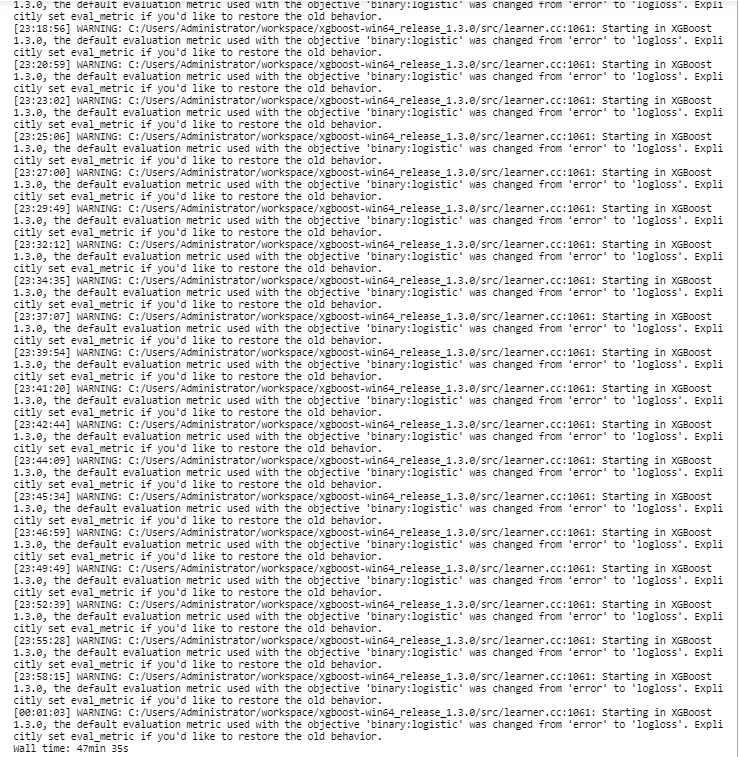

In [149]:
grid_best_model = grid_search.best_estimator_

In [150]:
y_test_proba=grid_search.predict_proba(X_test_st)[:,1]

In [151]:
len(y_test_proba)

8593

In [155]:
y_test_proba

array([0.03549657, 0.00394613, 0.00778068, ..., 0.06365503, 0.003324  ,
       0.47185835], dtype=float32)

In [156]:
roc_auc_score(y_test,y_test_proba)

0.6656584841461225

## Choose model 4 as final model

In [157]:
# standardscaler test_cleaned data
test_st=sc_X.transform(test_cleaned)

In [158]:
test_proba=grid_best_model.predict_proba(test_st)[:,1]

## Submission to Kaggle

In [159]:
kaggle_sub = pd.DataFrame(index=test_index.astype('int32'), data=test_proba)
kaggle_sub.rename(columns={0: "RESPONSE"}, inplace=True)
kaggle_sub.to_csv('kaggle_sub_1.csv')

In [160]:
kaggle_sub

,RESPONSE
LNR,
1754,0.021655
1770,0.031614
1465,0.004408
1470,0.010584
1478,0.007280
...,...
67615,0.433979
67938,0.005187
67942,0.009292
